In [3]:
from landnet.features.grids import Grid
from landnet.features.tiles import TileConfig, TileSize
from landnet import enums
from landnet import config
from pathlib import Path
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, jaccard_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import RFECV, RFE
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from imblearn.under_sampling import RandomUnderSampler
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

In [4]:
features = [var.value for var in enums.GeomorphometricalVariable]


def get_grid(variable: enums.GeomorphometricalVariable, mode: enums.Mode):
    out_dir = Path('./tiles_test_vis')
    out_dir.mkdir(exist_ok=True)
    path = config.GRIDS / mode.value / f'{variable.value}.tif'
    tile_config = TileConfig(TileSize(2000, 2000))
    grid = Grid(path, tile_config, mode)
    tile = grid.get_tile(index=0)[1].reshape(-1, 1)
    mask = grid.get_tile_mask(index=0)[1][1].flatten()

    return (tile, mask)


def stack_predictors(mode: enums.Mode):
    tiles = []
    for variable in list(enums.GeomorphometricalVariable):
        tile, mask = get_grid(variable, mode)
        tiles.append(tile)
    tiles = np.concatenate(tiles, axis=1)
    return (tiles, mask)  # type: ignore

In [5]:
train_tiles, train_mask = stack_predictors(enums.Mode.TRAIN)
# test_tiles, test_mask = stack_predictors(enums.Mode.TEST)
validation_tiles, validation_mask = stack_predictors(enums.Mode.VALIDATION)
print('Predictors:', train_tiles.shape, 'Mask:', train_mask.shape)
assert train_tiles.shape[0] == train_mask.shape[0]
print(train_tiles)

Predictors: (4000000, 36) Mask: (4000000,)
[[ 6.0400143e-02  2.7990876e-02 -2.6287458e+01 ...  1.1415929e+00
   5.9071116e+00  9.6104997e-01]
 [ 6.1817639e-02  2.8728288e-02 -1.2802164e+01 ...  1.5303116e-01
   4.1477442e+00  9.6872687e-01]
 [ 9.0721123e-02  4.0738273e-02 -8.5086088e+00 ...  1.4166234e-01
   3.7737935e+00  9.7258413e-01]
 ...
 [ 4.4745982e-02  2.2860173e-02  1.5074744e+01 ... -6.0447824e-01
   4.4396877e+00  1.0148772e+00]
 [ 5.1267125e-02  2.6019871e-02  1.8071127e+01 ... -4.4203228e-01
   4.2545252e+00  1.0075014e+00]
 [ 5.3801492e-02  2.6512727e-02  0.0000000e+00 ... -7.4933803e-01
   4.2131000e+00  9.9702185e-01]]


In [6]:
assert train_tiles.shape[0] == 4000000
undersampler = RandomUnderSampler(random_state=0)
train_tiles_undersample, train_mask_undersample = undersampler.fit_resample(  # type: ignore
    train_tiles, train_mask
)  # type: ignore
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
for _, sample_idx in split.split(
    train_tiles_undersample,
    train_mask_undersample,  # type: ignore
):
    train_tiles_stratified = train_tiles_undersample[sample_idx]
    train_mask_stratified = train_mask_undersample[sample_idx]
unique, counts = np.unique(train_mask_stratified, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 31510]
 [    1 31510]]


In [7]:
space = {
    'eta': hp.loguniform('eta', np.log(1e-3), np.log(1.0)),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-6), np.log(2.0)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-6), np.log(2.0)),
    'gamma': hp.loguniform('gamma', np.log(1e-6), np.log(64.0)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'max_depth': hp.qloguniform('max_depth', np.log(2), np.log(8), 1),
    'n_estimators': hp.qloguniform('n_estimators', np.log(2), np.log(1024), 1),
}


def get_classifier(space):
    space['max_depth'] = int(space['max_depth'])
    space['n_estimators'] = int(space['n_estimators'])
    print(space)
    return xgb.XGBClassifier(
        eval_metric='auc',
        # early_stopping_rounds=10,
        **space,
    )


def fit(space):
    clf = get_classifier(space)

    evaluation = [
        (train_tiles_stratified, train_mask_stratified),
        (validation_tiles, validation_mask),
    ]

    clf.fit(
        train_tiles_stratified,
        train_mask_stratified,
        eval_set=evaluation,
        verbose=False,
    )
    return clf


def objective(space):
    clf = fit(space)

    pred = clf.predict(validation_tiles)
    # accuracy = accuracy_score(validation_mask, pred > 0.5)
    # f_beta = fbeta_score(validation_mask, pred > 0.5, beta=2)
    jaccard = jaccard_score(validation_mask, pred > 0.5)
    report = classification_report(validation_mask, pred > 0.5)
    print('SCORE:', jaccard)
    return {'loss': -jaccard, 'status': STATUS_OK, 'report': report}

In [8]:
# trials = Trials()

# best_hyperparams = fmin(
#     fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials
# )

with open(
    config.PROCESSED_DATA_DIR / 'xgboost_trials_result.pkl', mode='rb'
) as file:
    trials: Trials = pickle.load(file)
best_hyperparameters = {
    k: v[0] for k, v in trials.best_trial['misc']['vals'].items()
}
best_model = fit(best_hyperparameters)
best_model.feature_names_in_ = features

{'colsample_bytree': np.float64(0.47946460448915673), 'eta': np.float64(0.06880244492754263), 'gamma': np.float64(1.6404304997133747e-06), 'max_depth': 7, 'n_estimators': 523, 'reg_alpha': np.float64(0.00044757844420767283), 'reg_lambda': np.float64(9.653751783560203e-06), 'subsample': np.float64(0.6114606930608127)}


AttributeError: property 'feature_names_in_' of 'XGBClassifier' object has no setter

In [ ]:
selector = RFECV(
    get_classifier(best_hyperparameters), step=1, cv=10, verbose=True
)
selector = selector.fit(train_tiles_stratified, train_mask_stratified)
with open(config.PROCESSED_DATA_DIR / 'xgboost_rfecv.pkl', mode='wb') as file:
    pickle.dump(selector, file)

{'colsample_bytree': np.float64(0.47946460448915673), 'eta': np.float64(0.06880244492754263), 'gamma': np.float64(1.6404304997133747e-06), 'max_depth': 7, 'n_estimators': 523, 'reg_alpha': np.float64(0.00044757844420767283), 'reg_lambda': np.float64(9.653751783560203e-06), 'subsample': np.float64(0.6114606930608127)}
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 feature

In [9]:
def print_selected_features(selector):
    print('Selected features:')
    for i, val in enumerate(selector.ranking_):
        if val == 1:
            print(features[i])

In [10]:
selector = RFE(
    get_classifier(best_hyperparameters),
    step=1,
    verbose=True,
    n_features_to_select=5,
)
selector = selector.fit(train_tiles_stratified, train_mask_stratified)
print_selected_features(selector)

{'colsample_bytree': np.float64(0.47946460448915673), 'eta': np.float64(0.06880244492754263), 'gamma': np.float64(1.6404304997133747e-06), 'max_depth': 7, 'n_estimators': 523, 'reg_alpha': np.float64(0.00044757844420767283), 'reg_lambda': np.float64(9.653751783560203e-06), 'subsample': np.float64(0.6114606930608127)}
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 feature

In [51]:
selector.ranking_
for i, val in enumerate(selector.ranking_):
    if val == 1:
        print(features[i])


slope
shade
conv
poso
nego
aspect
northness
eastness
cmini
ctota
dem
area
tpi
vld
tri
vrm
cup
clu
cdo
cdl
flow
fpl
spl
wind


In [24]:
vif = [
    variance_inflation_factor(train_tiles_stratified, i)
    for i in range(len(enums.GeomorphometricalVariable))
]

In [25]:
df_vif = pd.DataFrame(np.array([features, vif]).T, columns=['variable', 'vif'])
df_vif['vif'] = df_vif['vif'].astype(float)
df_vif.sort_values(by='vif', ascending=False)

,variable,vif
15,ccros,1365.889200
20,area,731.352050
17,cmaxi,691.017600
4,poso,461.115200
35,wind,383.795040
11,cgene,302.734000
12,croto,133.867520
14,clong,117.610220
3,conv,93.981580
23,tri,92.166810


In [38]:
def plot_feature_importance(feature_importances, ax):
    series = pd.Series(feature_importances).sort_values()
    sns.barplot(
        series,
        orient='y',
        ax=ax,
    )

<Axes: >

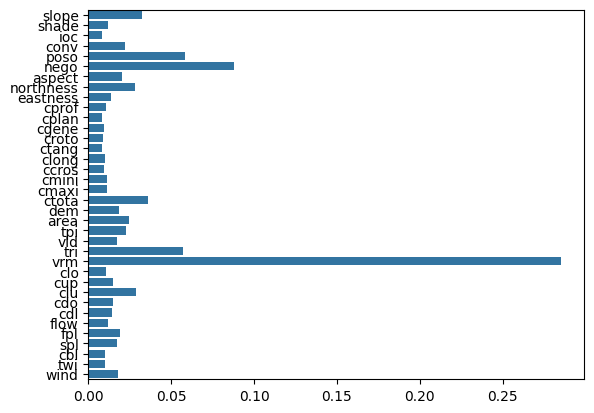

In [37]:
importances = {
    k.value: v
    for k, v in zip(
        enums.GeomorphometricalVariable, best_model.feature_importances_
    )
}
importance = best_model.importance_type

sns.barplot(importances, orient='h')


In [35]:
best_model.get_booster().get_score(importance_type='gain')

{'f0': 10.549221992492676,
 'f1': 3.7392194271087646,
 'f2': 2.712404489517212,
 'f3': 7.0714497566223145,
 'f4': 18.925859451293945,
 'f5': 28.57318115234375,
 'f6': 6.516083717346191,
 'f7': 9.014739990234375,
 'f8': 4.400167942047119,
 'f9': 3.457244634628296,
 'f10': 2.7192158699035645,
 'f11': 2.9882571697235107,
 'f12': 2.852569818496704,
 'f13': 2.689103364944458,
 'f14': 3.141052722930908,
 'f15': 2.9813594818115234,
 'f16': 3.6462833881378174,
 'f17': 3.607935905456543,
 'f18': 11.59848403930664,
 'f19': 6.0142927169799805,
 'f20': 7.9526872634887695,
 'f21': 7.322188854217529,
 'f22': 5.571471691131592,
 'f23': 18.57033920288086,
 'f24': 92.45301055908203,
 'f25': 3.491987943649292,
 'f26': 4.87805700302124,
 'f27': 9.213433265686035,
 'f28': 4.841946601867676,
 'f29': 4.65590238571167,
 'f30': 3.916924238204956,
 'f31': 6.233918190002441,
 'f32': 5.598134994506836,
 'f33': 3.216726541519165,
 'f34': 3.300693988800049,
 'f35': 5.725746154785156}

100%|===================| 63002/63020 [31:12<00:00]        

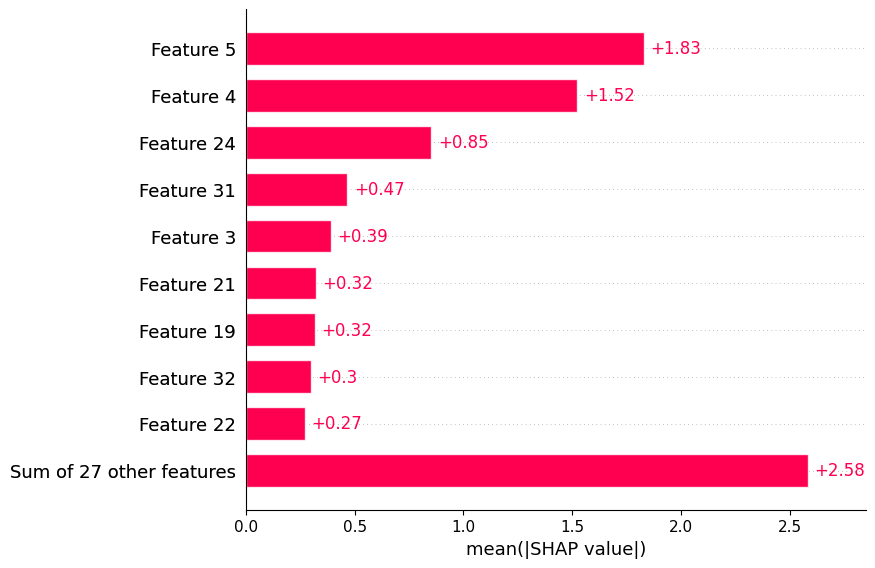

In [ ]:
explainer = shap.Explainer(best_model, train_tiles_stratified)
shap_values = explainer(train_tiles_stratified)
clustering = shap.utils.hclust(train_tiles_stratified, train_mask_stratified)
shap_values.feature_names = list(
    enums.GeomorphometricalVariable._value2member_map_
)

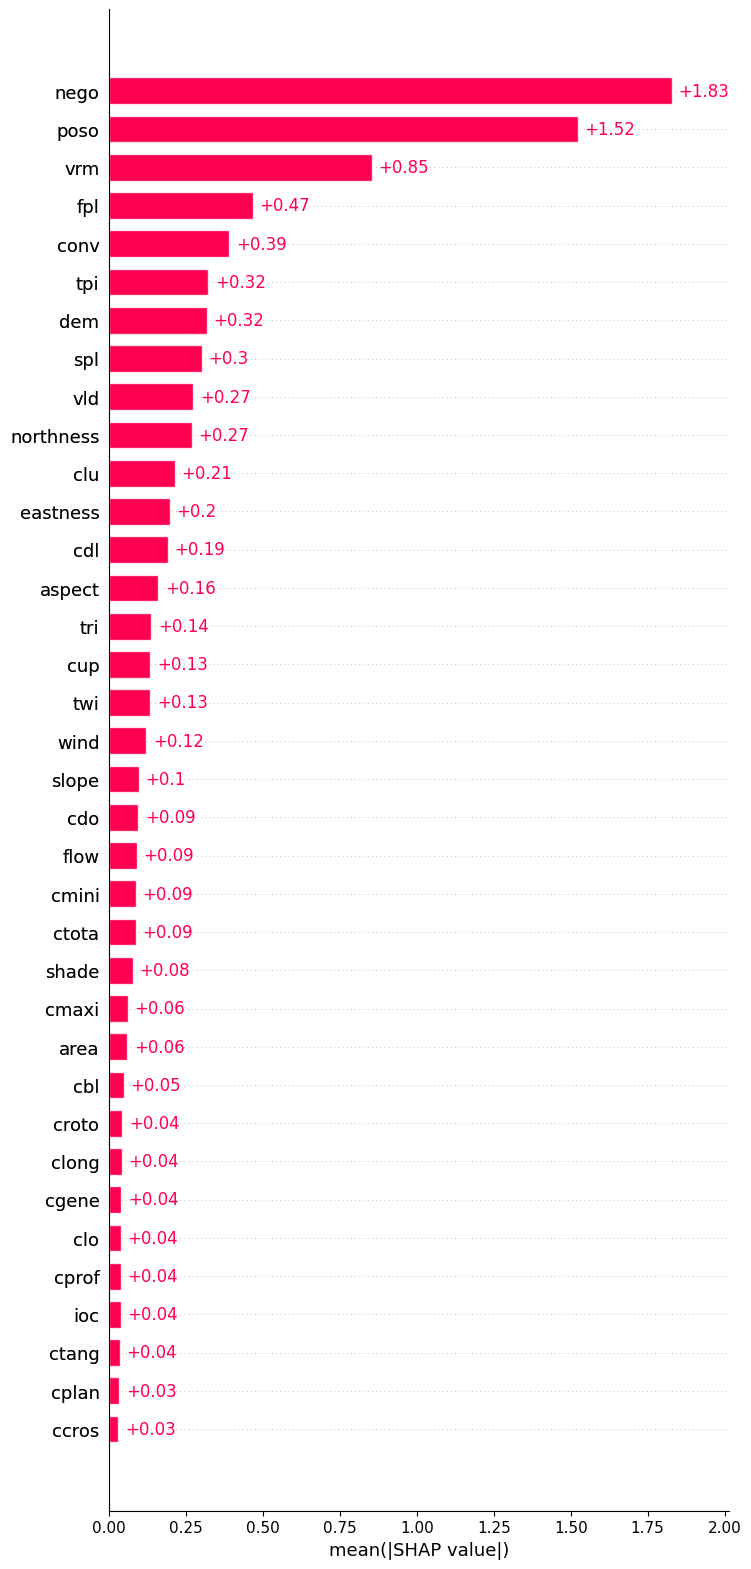

In [39]:
shap.plots.bar(shap_values, max_display=36)

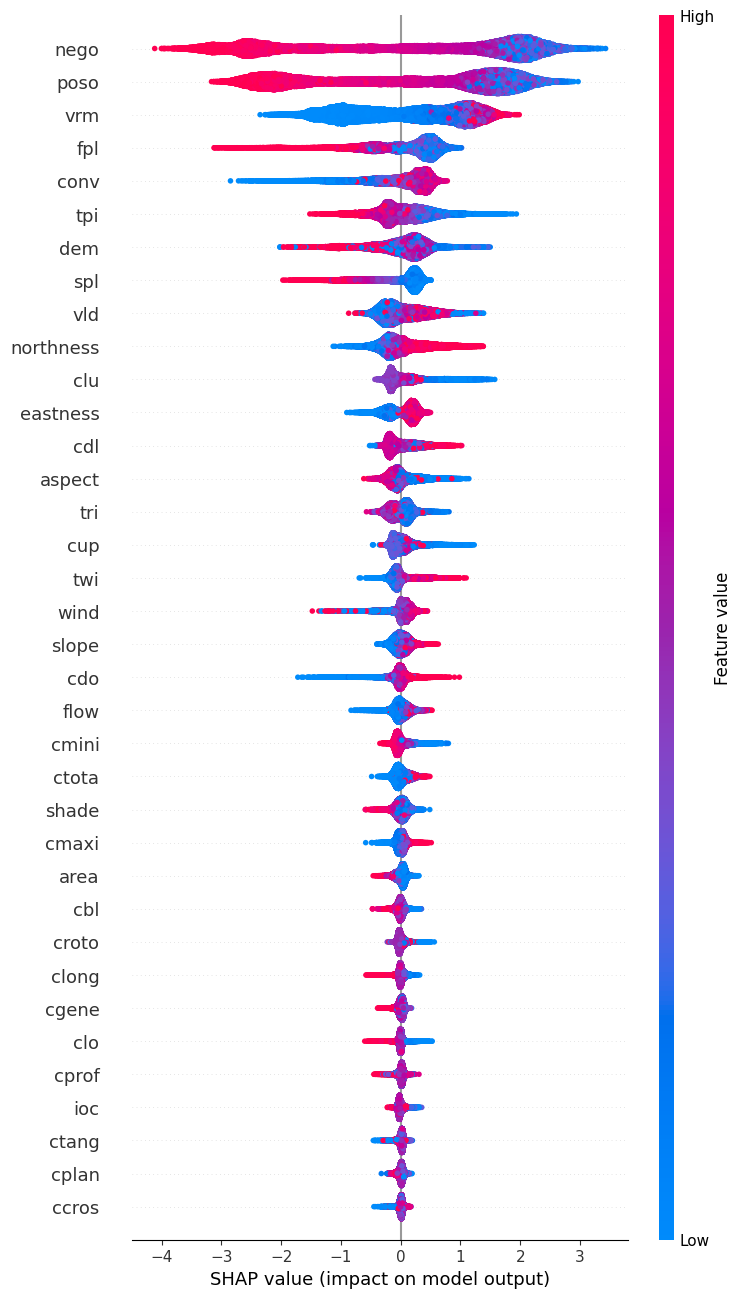

In [40]:
shap_values.feature_names = list(
    enums.GeomorphometricalVariable._value2member_map_
)
shap.plots.beeswarm(shap_values, max_display=36)

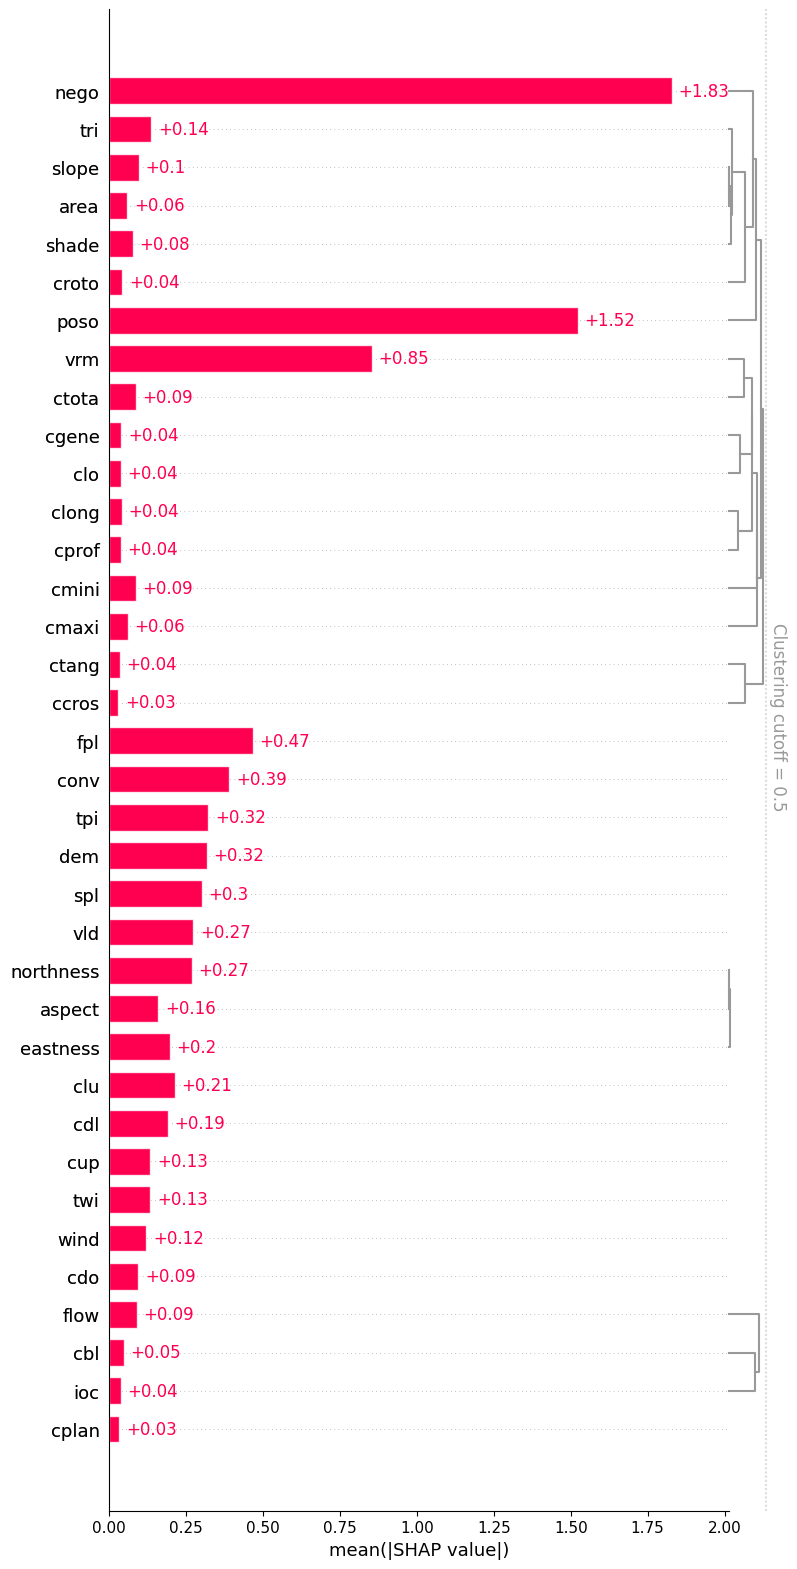

In [47]:
shap.plots.bar(shap_values, clustering=clustering, max_display=36)

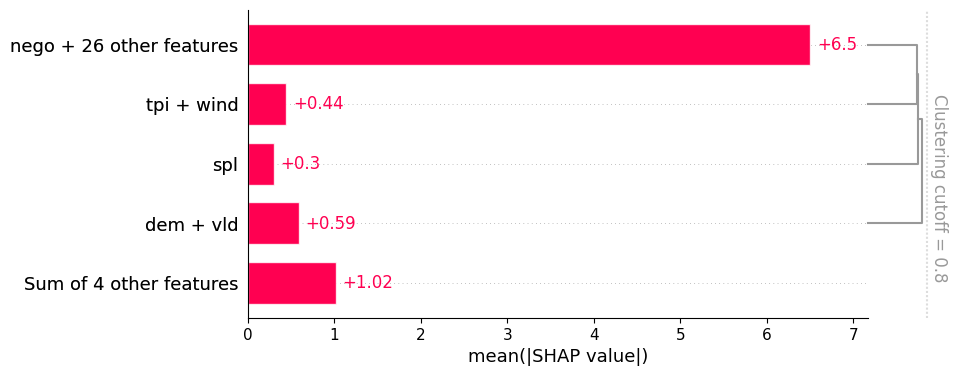

In [49]:
shap.plots.bar(
    shap_values, clustering=clustering, clustering_cutoff=0.8, max_display=5
)

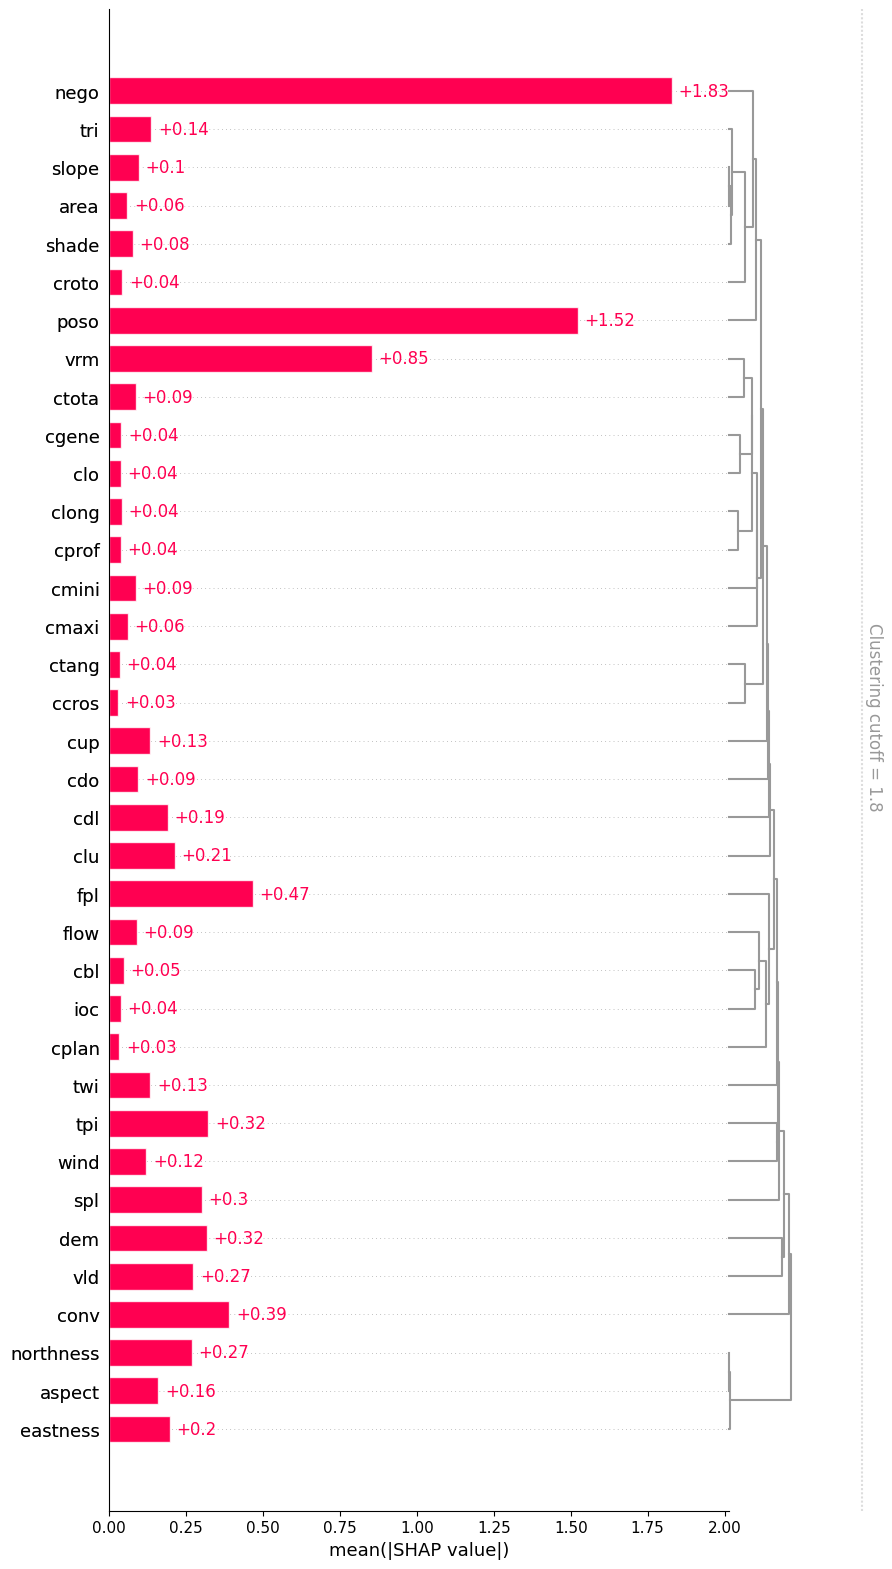

In [44]:
shap.plots.bar(
    shap_values, clustering=clustering, clustering_cutoff=1.8, max_display=36
)